## Notebook to Generate CSV Forecast (Prophet and LSTM)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install -r requirements.txt

     |████████████████████████████████| 17.3MB 200kB/s 
     |████████████████████████████████| 10.5MB 44.9MB/s 
     |████████████████████████████████| 112kB 54.7MB/s 
     |████████████████████████████████| 13.1MB 243kB/s 
     |████████████████████████████████| 8.1MB 21.1MB/s 
     |████████████████████████████████| 7.0MB 40.4MB/s 
     |████████████████████████████████| 92.6MB 33kB/s 
     |████████████████████████████████| 1.5MB 44.0MB/s 
     |████████████████████████████████| 727kB 42.1MB/s 
     |████████████████████████████████| 51kB 7.8MB/s 
     |████████████████████████████████| 92kB 13.9MB/s 
     |████████████████████████████████| 3.2MB 54.7MB/s 
     |████████████████████████████████| 368kB 52.7MB/s 
     |████████████████████████████████| 51kB 8.3MB/s 
  Created wheel for fbprophet: filename=fbprophet-0.5-cp36-none-any.whl size=6613613 sha256=d85b5206a250b4da8780538f3f222a0339414fe720fcbd987bff1704599f573b
  Stored in directory: /root/.cache/pip/wheels/16/61/45/2dce71b1

In [7]:
!cp drive/My\ Drive/bitstampUSD_1-min_data_2012-01-01_to_2020-09-14.csv .

Data Link - kaggle.com/mczielinski/bitcoin-historical-data

In [4]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [5]:
import pandas as pd
import json
from datetime import datetime
import numpy as np
from fbprophet import Prophet
import pickle
import math

ERROR:fbprophet:Importing matplotlib failed. Plotting will not work.


# Read Bitstamp Data

First, let's read in the data from Kaggle.

In [8]:
df = pd.read_csv('bitstampUSD_1-min_data_2012-01-01_to_2020-09-14.csv')

In [9]:
df['ds'] = df['Timestamp'].apply(lambda x: datetime.fromtimestamp(x))

In [ ]:
df.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,ds
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.0,4.39,2011-12-31 07:52:00
1,1325317980,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011-12-31 07:53:00
2,1325318040,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011-12-31 07:54:00
3,1325318100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011-12-31 07:55:00
4,1325318160,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011-12-31 07:56:00


# Train Model Using Prophet

Next, let's take the log of weighted price and train our model using that feature.

In [10]:
df['y'] = np.log(df['Weighted_Price'])

In [11]:
df_subset = df[df['ds'] >= pd.Timestamp('2020-01-01')]

In [ ]:
m = Prophet()

In [ ]:
df_subset.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,ds,y
4202176,1577836800,7160.69,7160.69,7159.64,7159.64,5.501691,39392.484606,7160.068520,2020-01-01 00:00:00,8.876275
4202177,1577836860,7161.51,7161.51,7155.09,7161.20,3.776924,27047.304680,7161.198209,2020-01-01 00:01:00,8.876433
4202178,1577836920,7158.82,7158.82,7158.82,7158.82,0.029278,209.595359,7158.820000,2020-01-01 00:02:00,8.876100
4202179,1577836980,7158.82,7158.82,7156.90,7156.90,0.065819,471.156094,7158.321885,2020-01-01 00:03:00,8.876031
4202180,1577837040,7158.50,7158.50,7154.97,7157.20,0.971387,6950.500833,7155.235666,2020-01-01 00:04:00,8.875600


In [ ]:
m.fit(df_subset[['ds','y']]);

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Only run the below if you want to save a **NEW** model

In [ ]:
with open('btc_model.pickle', 'wb') as pickle_file:
    pickle.dump(m, pickle_file)
    pickle_file.close()

Use this if you've already trained the model

In [ ]:
with open('btc_model.pickle', 'rb') as pickle_file:
    m = pickle.Unpickler(pickle_file)
    m = m.load()

# Generate Prediction

Now, let's predict out prices using the model we just trained.

In [ ]:
future = m.make_future_dataframe(periods=150000, freq='1min', include_history=False)
future.tail()

,ds
149995,2020-12-27 03:56:00
149996,2020-12-27 03:57:00
149997,2020-12-27 03:58:00
149998,2020-12-27 03:59:00
149999,2020-12-27 04:00:00


In [ ]:
fcst = m.predict(future)

In [ ]:
fcst.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,yhat_exp
149995,2020-12-27 03:56:00,9.309503,3.033778,15.412779,3.018663,15.439142,-0.004977,-0.004977,-0.004977,0.000223,0.000223,0.000223,-0.005200,-0.005200,-0.005200,0.0,0.0,0.0,9.304526,10987.639775
149996,2020-12-27 03:57:00,9.309503,3.033502,15.475362,3.018543,15.439247,-0.004988,-0.004988,-0.004988,0.000219,0.000219,0.000219,-0.005207,-0.005207,-0.005207,0.0,0.0,0.0,9.304515,10987.516673
149997,2020-12-27 03:58:00,9.309503,2.994632,15.426393,3.018424,15.439352,-0.004999,-0.004999,-0.004999,0.000216,0.000216,0.000216,-0.005215,-0.005215,-0.005215,0.0,0.0,0.0,9.304504,10987.392959
149998,2020-12-27 03:59:00,9.309503,2.960968,15.407880,3.018305,15.439457,-0.005011,-0.005011,-0.005011,0.000212,0.000212,0.000212,-0.005223,-0.005223,-0.005223,0.0,0.0,0.0,9.304492,10987.268638
149999,2020-12-27 04:00:00,9.309503,2.994598,15.466743,3.018186,15.439562,-0.005022,-0.005022,-0.005022,0.000209,0.000209,0.000209,-0.005231,-0.005231,-0.005231,0.0,0.0,0.0,9.304481,10987.143716


We can use our forecast (`fcst`) to plot the prediction we just made:

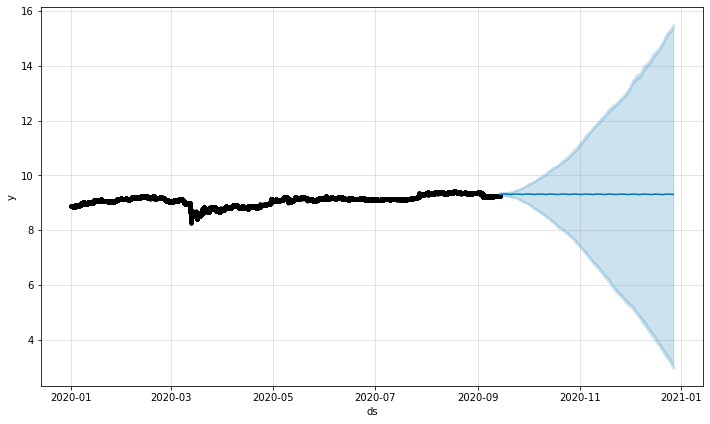

In [ ]:
m.plot(fcst);

Now let's convert our `log(price)` back to price and calculate whether the minute is a buy or sell minute

In [ ]:
fcst['yhat_exp'] = fcst['yhat'].apply(lambda x: math.exp(x))

In [ ]:
output = fcst[fcst['ds'] > '2020-01-01'][['ds','yhat_exp']]

In [ ]:
output['delta'] = output.yhat_exp.diff()

In [ ]:
output = output[output['ds'] > '2019-12-25']

In [ ]:
def choose_side(x):
    if x > 0:
        return 'buy'
    else: 
        return 'sell'

In [ ]:
output['side'] = output['delta'].apply(lambda x: choose_side(x))

We can count the number of buy vs. sell minutes with:

In [ ]:
output.groupby('side')['ds'].count()

side
buy     71597
sell    78403
Name: ds, dtype: int64

# Store Output

Save file to CSV

In [ ]:
output[['ds','side']].to_csv('2020_full_trade_forecast.csv', index=False)

# Analyze Output

Generate a components plot

In [ ]:
fcst_sampled = fcst[fcst['ds'] > '2020-01-01 00:00:00']

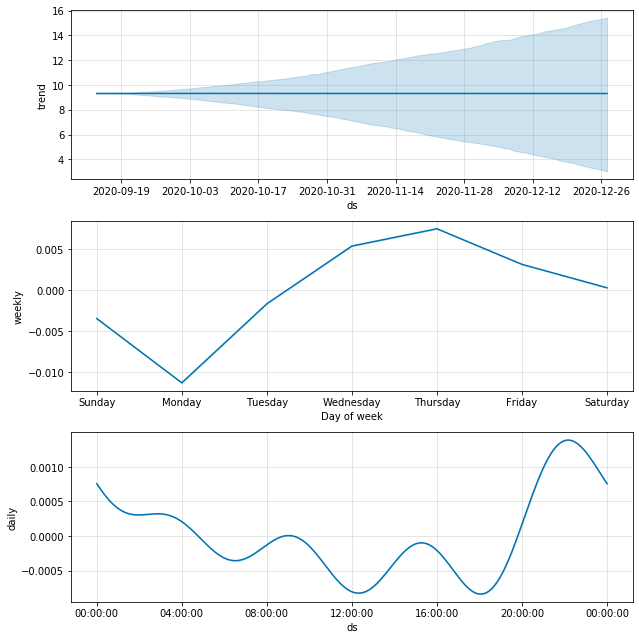

In [ ]:
a = m.plot_components(fcst_sampled)

You can save the components plot to a file if you'd like

In [ ]:
a.savefig('components_plot.png', dpi=200)

# Train Model Using LSTM 

In [ ]:
from ts_utils import *

In [14]:
ts = df_subset[['ds','y']].set_index('ds')

In [ ]:
ts.head()

,y
ds,
2020-01-01 00:00:00,8.876275
2020-01-01 00:01:00,8.876433
2020-01-01 00:02:00,8.876100
2020-01-01 00:03:00,8.876031
2020-01-01 00:04:00,8.875600


In [16]:
ts = ts.iloc[:,0]

In [18]:
ts = ts.dropna(0)

ds
2020-01-01 00:00:00    8.876275
2020-01-01 00:01:00    8.876433
2020-01-01 00:02:00    8.876100
2020-01-01 00:03:00    8.876031
2020-01-01 00:04:00    8.875600
                         ...   
2020-09-13 23:56:00    9.242267
2020-09-13 23:57:00    9.242947
2020-09-13 23:58:00    9.242437
2020-09-13 23:59:00    9.243192
2020-09-14 00:00:00    9.243043
Name: y, Length: 363692, dtype: float64

In [ ]:
s = 200
model = models.Sequential()
model.add( layers.LSTM(input_shape=(1,s), units=50, activation='relu', return_sequences=False) )
model.add( layers.Dense(1) )
model.compile(optimizer='adam', loss='mean_absolute_error')
model.summary()

Instructions for updating:
Colocations handled automatically by placer.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50)                50200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 50,251
Trainable params: 50,251
Non-trainable params: 0
_________________________________________________________________


In [ ]:
  s = model.input_shape[-1]
  X, y, scaler = utils_preprocess_ts(ts, scaler=None, exog=None, s=s)

In [ ]:
training = model.fit(x=X, y=y, batch_size=1, epochs=1, shuffle=True, verbose=1, validation_split=0.3)

Instructions for updating:
Use tf.cast instead.


Train on 254444 samples, validate on 109048 samples
254444/254444 [==============================] - 594s 2ms/sample - loss: 0.0059 - val_loss: 0.0025


In [ ]:
dtf = None
dtf = ts.to_frame(name="ts")
dtf["model"] = utils_fitted_lstm(ts, training.model, scaler, None)
dtf["model"] = dtf["model"].fillna(method='bfill')

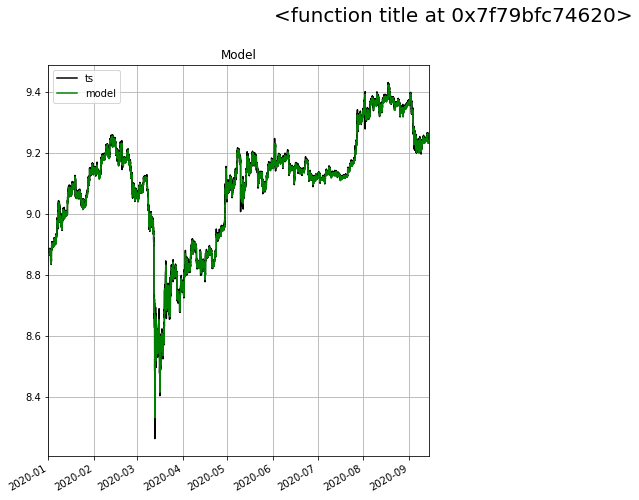

In [ ]:
fig = plt.figure(figsize=(15,8))
fig.suptitle(title, fontsize=20)   
ax1 = fig.add_subplot(1,2, 1)
dtf[pd.notnull(dtf["model"])][["ts","model"]].plot(color=["black","green"], title="Model", grid=True, ax=ax1)      
ax1.set(xlabel=None)

plt.show()

In [ ]:
fig.savefig('LSTM_fitted.png', dpi=200)

In [ ]:
## index
index = utils_generate_indexdate(start=ts.index[-1], end='2021-01-01 00:00:00', n=None, freq="1min")

## forecast
preds = utils_predict_lstm(ts[-s:], training.model, scaler, pred_ahead=len(index), exog=None)

dtf = dtf.append(pd.DataFrame(data=preds, index=index, columns=["forecast"]))

--- generating index date --> start: 2020-09-14 00:01:00 | end: 2021-01-01 00:00:00 | len: 156960 ---
[9.242122 9.242099 9.242135 ... 9.239873 9.239873 9.239873]


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7123: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




In [ ]:
df = dtf.reset_index()
output = df[df['index'] > '2020-09-14'][['index','forecast']]
output['delta'] = output.forecast.diff()
output['side'] = output['delta'].apply(lambda x: choose_side(x))
output.groupby('side')['index'].count()

side
buy         74
sell    156886
Name: index, dtype: int64

In [ ]:
output[['index','side']].to_csv('2020_full_trade_forecast_LSTM.csv', index=False)